In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, ttest_1samp
from sklearn.feature_selection import SelectKBest, f_classif
import scienceplots

plt.style.use(["grid", "notebook", "science", "ieee"])

In [2]:
df = pd.read_csv("../data.csv")
X = df.drop(['diagnosis', 'id', 'Unnamed: 32'], axis=1)
y = df['diagnosis']
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df.eq(0).sum()
mean_con = df[df['concavity_mean'] != 0]['concavity_mean'].mean()
mean_con_m = df[df['concave points_mean'] != 0]['concave points_mean'].mean()
mean_con_se = df[df['concavity_se'] != 0]['concavity_se'].mean()
mean_con_m_se = df[df['concave points_se'] != 0]['concave points_se'].mean()
mean_con_w = df[df['concavity_worst'] != 0]['concavity_worst'].mean()
mean_con_m_w = df[df['concave points_worst'] != 0]['concave points_worst'].mean()

df['concavity_mean'].replace(0, mean_con, inplace=True)
df['concave points_mean'].replace(0, mean_con_m, inplace=True)
df['concavity_se'].replace(0, mean_con_se, inplace=True)
df['concave points_se'].replace(0, mean_con_m_se, inplace=True)
df['concavity_worst'].replace(0, mean_con_w, inplace=True)
df['concave points_worst'].replace(0, mean_con_m_w, inplace=True)

# Select the top k features with SelectKBest
k = 10
selector = SelectKBest(f_classif, k=k)
selector.fit(X, y)

# Get the feature names and scores
feature_names = X.columns
scores = selector.scores_

# Sort the scores and get the top k
top_k_idxs = scores.argsort()[-k:]
top_k_features = [feature_names[i] for i in top_k_idxs]
top_k_scores = [scores[i] for i in top_k_idxs]

# Print the top k features and scores
print(f'Top {k} features: {top_k_features}')
print(f'Top {k} scores: {top_k_scores}')

Top 10 features: ['concavity_worst', 'concavity_mean', 'area_mean', 'radius_mean', 'area_worst', 'perimeter_mean', 'radius_worst', 'concave points_mean', 'perimeter_worst', 'concave points_worst']
Top 10 scores: [436.69193940305007, 533.7931262035503, 573.0607465682366, 646.9810209786473, 661.6002055336272, 697.235272476532, 860.7817069850373, 861.6760200073135, 897.9442188597807, 964.3853934517133]


In [4]:
X = X[top_k_features]

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, log_loss

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, shuffle=True)

In [7]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)

X_train_scaled = min_max_scaler.transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

In [8]:
knn = GridSearchCV(KNeighborsClassifier(), {
    "n_neighbors": [i for i in range(1, 21)],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "p": [1, 2],
}, scoring='accuracy', cv=5)

In [9]:
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

In [10]:
knn.best_params_

{'algorithm': 'auto', 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}

In [11]:
k_nearest_neighbors = KNeighborsClassifier(
    n_neighbors=knn.best_params_["n_neighbors"],
    weights=knn.best_params_["weights"],
    p=knn.best_params_["p"],
    algorithm=knn.best_params_["algorithm"]
)

In [12]:
k_nearest_neighbors.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=17, p=1, weights='distance')

In [13]:
y_pred = k_nearest_neighbors.predict(X_test_scaled)

In [14]:
pred_probabilities = k_nearest_neighbors.predict_proba(X_test_scaled)

In [15]:
print("Accuracy:", k_nearest_neighbors.score(X_test_scaled, y_test))

Accuracy: 0.9440559440559441


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.93      0.98      0.96        88
           M       0.96      0.89      0.92        55

    accuracy                           0.94       143
   macro avg       0.95      0.93      0.94       143
weighted avg       0.94      0.94      0.94       143



In [17]:
cm = confusion_matrix(y_test, y_pred)

cm

array([[86,  2],
       [ 6, 49]], dtype=int64)

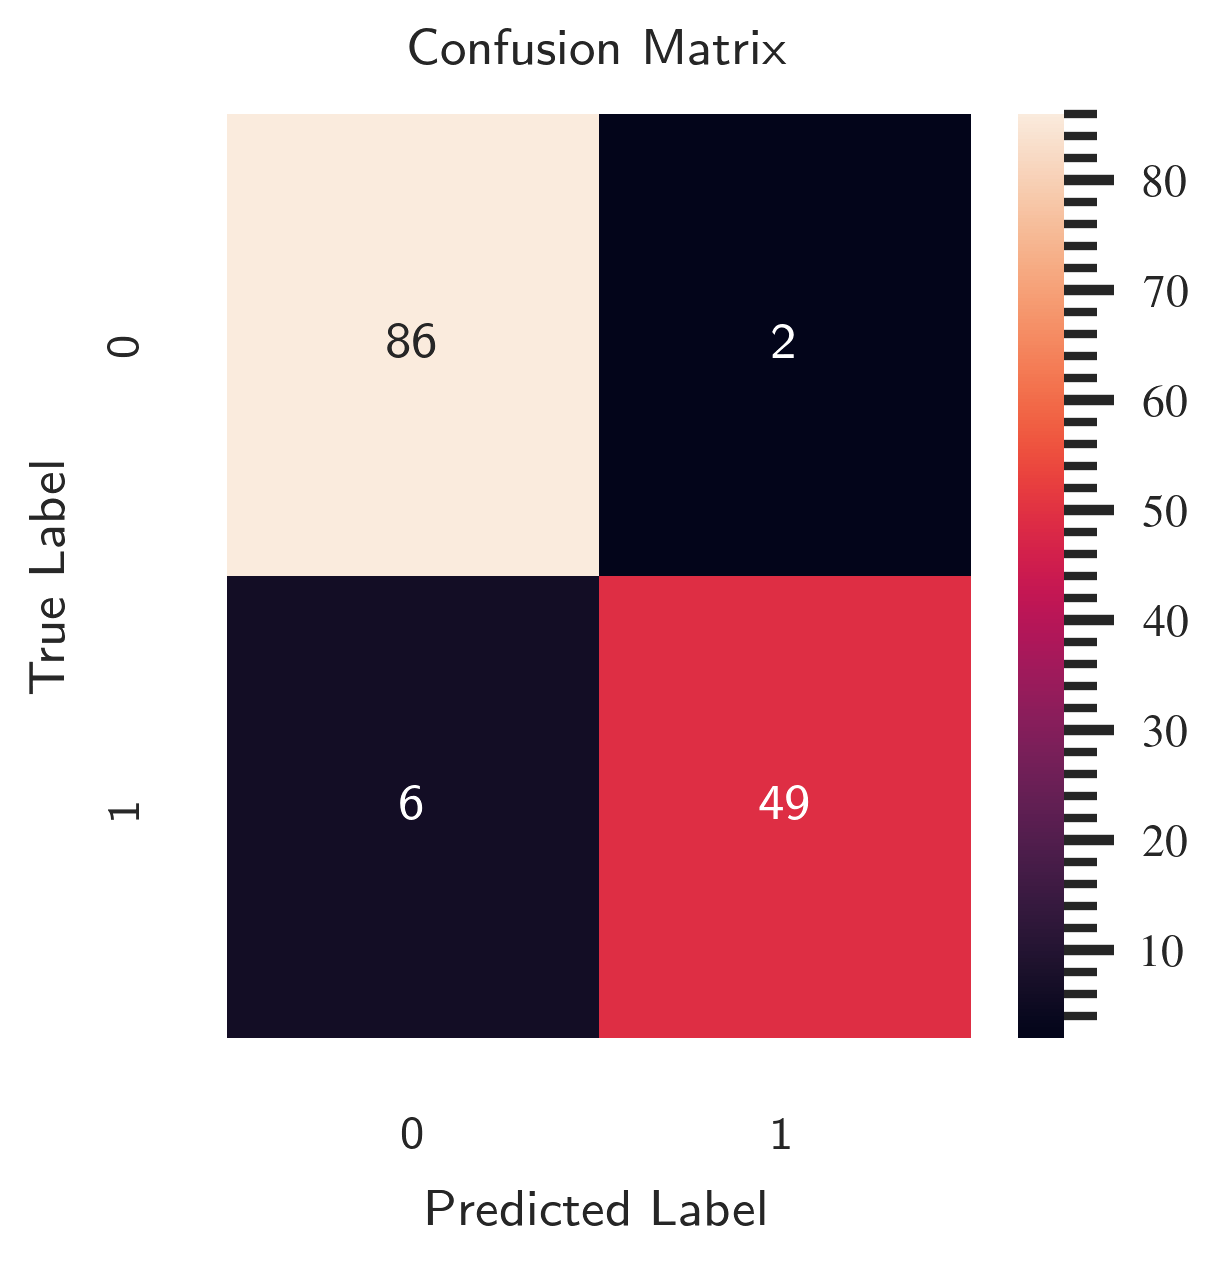

In [18]:
plt.figure(figsize=(2, 2))
sns.set(font_scale=.5)
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [19]:
k_fold = KFold(n_splits=10, random_state=2, shuffle=True)
cross_validation_score = cross_val_score(k_nearest_neighbors, X_test_scaled, y_test, cv=k_fold)

In [20]:
cross_validation_score.mean()

0.9433333333333334

In [21]:
cross_validation_score.std()

0.05334396152604827

In [22]:
print(f"Confidence Interval: {norm.interval(0.95, loc=cross_validation_score.mean(), scale=(cross_validation_score.std() / np.sqrt(len(cross_validation_score))))}")

Confidence Interval: (0.910271010976043, 0.9763956556906237)


In [23]:
t_statistic, p_value = ttest_1samp(cross_validation_score, 1)
print(f"This is the p-value of the t-test: {p_value}")

This is the p-value of the t-test: 0.011062122589677845
